## Gymnasium environments

This Section shows how you can make and use the `gym` environments that interface with the simulator.

In [1]:
import os
from pathlib import Path
import torch
import imageio
from IPython.display import HTML, Image

# Set working directory to the base directory 'gpudrive'
working_dir = Path.cwd()
while working_dir.name != 'gpudrive':
    working_dir = working_dir.parent
    if working_dir == Path.home():
        raise FileNotFoundError("Base directory 'gpudrive' not found")
os.chdir(working_dir)

from pygpudrive.env.config import EnvConfig, RenderConfig, SceneConfig, SelectionDiscipline
from pygpudrive.env.env_torch import GPUDriveTorchEnv

### Helper functions

In [2]:
def display_gif(filename, width=500, height=500):
    display(
        Image(
            data=open(filename, "rb").read(), format="gif", width=width, height=height
        )
    )

### Settings

In [3]:
EPISODE_LENGTH = 90  # Number of steps in each episode
MAX_NUM_OBJECTS = 128  # Maximum number of objects in the scene we control
NUM_WORLDS = 10  # Number of parallel environments
K_UNIQUE_SCENES = 3 # Number of unique scenes

# Set the path to where you want to save the videos
VIDEO_PATH = "./videos"

SCENE_NAME = "example_scene"

FPS = 4  # Video frames per second

### Initializing environments

- We provide both a torch and jax gymnasium interface with the simulator. Most functionality is specified in the `GPUDriveGymEnv` class in the `base_env`, `torch_env` and `jax_env` both inherit from the `GPUDriveGymEnv`, the only difference between these is that one exports torch tensors and the other jax arrays.
- All data settings are defined in the `SceneConfig` dataclass.
- All environment settings are defined in the `EnvConfig` dataclass. 
- All rendering configs are defined in the `RenderConfig` dataclass.


In [4]:
scene_config = SceneConfig(
    path="data", 
    num_scenes=NUM_WORLDS,
    discipline=SelectionDiscipline.K_UNIQUE_N,
    k_unique_scenes=K_UNIQUE_SCENES,
)

In [5]:
env_config = EnvConfig(
    steer_actions = torch.round(
        torch.linspace(-1.0, 1.0, 3), decimals=3),
    accel_actions = torch.round(
        torch.linspace(-3, 3, 3), decimals=3
    )
)

In [6]:
render_config = RenderConfig(
    resolution=(512, 512), # Quality of the rendered images
)

---

> **For more info about the environment configurations, see `pygpudrive/env/README.md`**

---

In [7]:
# MAKE ENV
env = GPUDriveTorchEnv(
    config=env_config,
    scene_config=scene_config,
    render_config=render_config,
    max_cont_agents=MAX_NUM_OBJECTS, # Maximum number of agents to control per scene
    device="cuda",
)

Compiling GPU engine code:
/home/emerge/gpudrive/external/madrona/src/mw/device/memory.cpp
/home/emerge/gpudrive/external/madrona/src/mw/device/state.cpp
/home/emerge/gpudrive/external/madrona/src/mw/device/crash.cpp
/home/emerge/gpudrive/external/madrona/src/mw/device/consts.cpp
/home/emerge/gpudrive/external/madrona/src/mw/device/taskgraph.cpp
/home/emerge/gpudrive/external/madrona/src/mw/device/taskgraph_utils.cpp
/home/emerge/gpudrive/external/madrona/src/mw/device/sort_archetype.cpp
/home/emerge/gpudrive/external/madrona/src/mw/device/host_print.cpp
/home/emerge/gpudrive/external/madrona/src/mw/../common/hashmap.cpp
/home/emerge/gpudrive/external/madrona/src/mw/../common/navmesh.cpp
/home/emerge/gpudrive/external/madrona/src/mw/../core/base.cpp
/home/emerge/gpudrive/external/madrona/src/mw/../physics/physics.cpp
/home/emerge/gpudrive/external/madrona/src/mw/../physics/geo.cpp
/home/emerge/gpudrive/external/madrona/src/mw/../physics/xpbd.cpp
/home/emerge/gpudrive/external/madrona/s

/home/emerge/gpudrive/src/level_gen.cpp(271): warning #177-D: function "gpudrive::createFloorPlane" was declared but never referenced
  static void createFloorPlane(Engine &ctx)
              ^

Remark: The warnings can be suppressed with "-diag-suppress <warning-number>"





### Run an episode with `N` parallel environments

A single rollout (one episode) is implemented as follows:
- We step through N worlds simultaneously.
- Use the `world_render_idx` argument in `render(.)` to select which world to render.

In [8]:
obs = env.reset()
frames = []

for _ in range(EPISODE_LENGTH):
    # SELECT ACTIONS
    rand_action = torch.Tensor(
        [[env.action_space.sample() for _ in range(MAX_NUM_OBJECTS * NUM_WORLDS)]]
    ).reshape(NUM_WORLDS, MAX_NUM_OBJECTS)

    # STEP
    env.step_dynamics(rand_action)

    obs = env.get_obs()
    reward = env.get_rewards()
    done = env.get_dones()

    # RENDER
    frame = env.render(world_render_idx=0)
    frames.append(frame)

### Display video

In [9]:
# Calculate duration between frames
duration = 1 / FPS

Path(f"{VIDEO_PATH}/{SCENE_NAME}").parent.mkdir(parents=True, exist_ok=True)

# Save the frames as a gif
imageio.mimsave(f"{VIDEO_PATH}/{SCENE_NAME}.gif", frames, duration=duration)

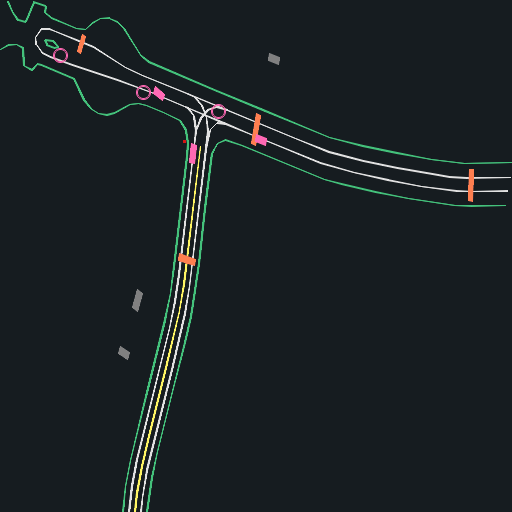

In [10]:
display(HTML(f"<h3>{SCENE_NAME}</h3>"))
display_gif(f"{VIDEO_PATH}/{SCENE_NAME}.gif")